# RAG Experiments - BioASQ Dataset

We start by defining a few constants and imports

In [1]:
DATASET_DIR = "../../datasets/bioasq/"

In [2]:
import os

DB_PATH = os.path.join(DATASET_DIR, "vector_db")
EVAL_PATH = os.path.join(DATASET_DIR, "eval.csv")

In [3]:
from langchain.chains import LLMChain, RetrievalQA, HypotheticalDocumentEmbedder
from langchain.prompts import PromptTemplate
from langchain_openai import OpenAIEmbeddings, OpenAI, ChatOpenAI
from langchain_chroma import Chroma

In [4]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = os.environ.get("OPENAI_API_KEY", getpass.getpass())

 ········


---

## Retrieval

### Naive

Standard retriever from Vector Store

In [5]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [6]:
naive_retriever = Chroma(persist_directory=DB_PATH, embedding_function=embeddings).as_retriever()

### Hyde (Hypothetical Document Embeddings)

HyDE retriever from Vector Store

In [7]:
base_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [8]:
prompt_template = "Please answer the question \nQuestion: {question}\nAnswer:"
prompt = PromptTemplate(input_variables=["question"], template=prompt_template)

generative_model = OpenAI(model="gpt-3.5-turbo-instruct")

retriever_chain = LLMChain(llm=generative_model, prompt=prompt)

/Users/knethil/projects/dense-rags/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [9]:
embeddings = HypotheticalDocumentEmbedder(
    llm_chain=retriever_chain, base_embeddings=base_embeddings
)

In [10]:
hyde_retriever = Chroma(persist_directory=DB_PATH, embedding_function=embeddings).as_retriever()

---

## Generation

Retriever uses Query to get Context Documents from the Vector Store. Both Query and Context are used to prompt a generative model for the Answer.

In [11]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

In [12]:
prompt_template = '''You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:'''

prompt = PromptTemplate(input_variables=["question", "context"], template=prompt_template)

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)

In [13]:
def get_chain(retriever, llm, prompt):
    qa_chain = RetrievalQA.from_chain_type(
        llm,
        retriever=retriever,
        chain_type_kwargs={"prompt": prompt},
        return_source_documents=True,
    )
    return qa_chain

### Naive output

In [14]:
# Cost/compute intensive

question = "What is a good book for adults with depression?"
naive_rag = get_chain(naive_retriever, llm, prompt)
result = naive_rag.invoke({"query": question})
result["result"]

'A good book for adults with depression may not be specifically mentioned in the provided context.'

### HyDE output

In [15]:
# Cost/compute intensive

question = "What is a good book for adults with depression?"
hyde_rag = get_chain(hyde_retriever, llm, prompt)
result = hyde_rag.invoke({"query": question})
result["result"]

"I don't know."

---

## Evaluation

Ragas evaluators are used to measure performance of Retrievers on a synthetic dataset

### Metrics

In [16]:
import nest_asyncio
from ragas.integrations.langchain import EvaluatorChain
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
)

# create eval chains
eval_chains = {
    m.name: EvaluatorChain(metric=m) 
    for m in [faithfulness, answer_relevancy, context_precision, context_recall]
}

In [17]:
# evaluate
def evaluate(sample):
    metrics = {}
    for name, eval_chain in eval_chains.items():
        score_name = f"{name}"
        metrics[score_name] = eval_chain(sample)[name]
        # print(f"{score_name}: {metrics[score_name]}")
    return metrics

In [18]:
#collect metrics

from tqdm.auto import tqdm

nest_asyncio.apply()

def get_metrics(results): 
    metrics = []
    for res in tqdm(results):
        sample= {
            "question": res["query"],
            "answer": res["result"],
            "contexts": [context.page_content for context in res["source_documents"]],
            "ground_truth": res["ground_truth"],
        }
        metrics.append(evaluate(sample))
    return metrics

### Dataset

In [31]:
EVAL_SIZE = 10

In [32]:
import pandas as pd

eval_df = pd.read_csv(EVAL_PATH)
eval_df.head()

,question,answer
0,Is the 22-item sino-nasal outcome test (SNOT-2...,Conclusion. The German-SNOT-22 validated here ...
1,Is the apilimod inhibitor effective against SA...,To identify therapeutics that can be repurpose...
2,What is OAC CHV?,The Open Access and Collaborative Consumer Hea...
3,Which test is used to diagnose colour synesthe...,A standardized test battery for the study of s...
4,Fusarium oxysporum f. sp lycopersici. is a pla...,Fusarium oxysporum f. sp lycopersici.produces ...


In [33]:
eval_questions = eval_df["question"].to_list()
eval_answers = eval_df["answer"].to_list()

examples = [
    {"query": q, "ground_truth": eval_answers[i]}
    for i, q in enumerate(eval_questions)
]

In [34]:
import random

examples = random.sample(examples, EVAL_SIZE)

### Naive RAG

In [35]:
# Cost/compute intensive

results = naive_rag.batch(examples)

In [36]:
# Cost/compute intensive

metrics = get_metrics(results)

  0%|          | 0/10 [00:00<?, ?it/s]

In [37]:
naive_metrics_df = pd.DataFrame(metrics)
naive_metrics_df.mean()

faithfulness         0.850000
answer_relevancy     0.831231
context_precision    0.891667
context_recall       0.711111
dtype: float64

### HyDE RAG

In [38]:
# Cost/compute intensive

results = hyde_rag.batch(examples)

In [39]:
# Cost/compute intensive

metrics = get_metrics(results)

  0%|          | 0/10 [00:00<?, ?it/s]

In [40]:
hyde_metrics_df = pd.DataFrame(metrics)
hyde_metrics_df.mean()

faithfulness         0.871212
answer_relevancy     0.915349
context_precision    0.922222
context_recall       0.750000
dtype: float64

---

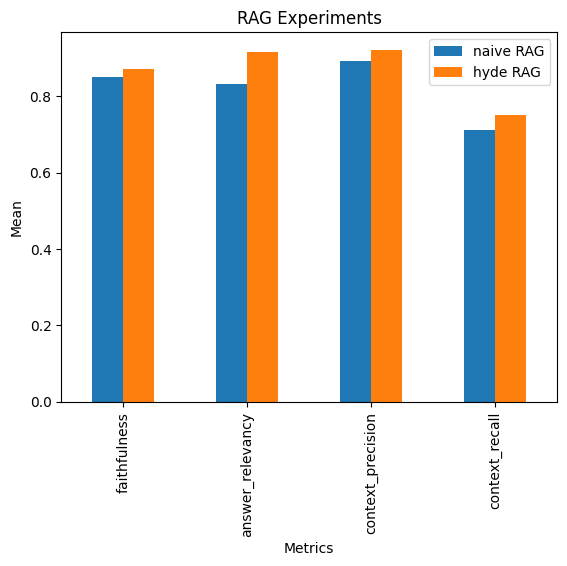

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

combined_metrics = pd.DataFrame(
    {
        "naive RAG": naive_metrics_df.mean(),
        "hyde RAG": hyde_metrics_df.mean(),        
    }
)

# plot combined metrics
combined_metrics.plot(kind='bar')
plt.title('RAG Experiments')
plt.ylabel('Mean')
plt.xlabel('Metrics')
plt.show()